In [1]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def rotation_z (theta):
    return np.array ([[ np.cos(theta) , -np.sin(theta) , 0 ],
                      [ np.sin(theta) ,  np.cos(theta) , 0 ],
                      [ 0             ,  0             , 1 ]])
  
def rotation_y (theta):
    return np.array ([[  np.cos(theta) , 0 , np.sin(theta) ],
                      [  0             , 1 , 0             ],
                      [ -np.sin(theta) , 0 , np.cos(theta) ]])

def rotation_x (theta):
    return np.array ([[ 1 , 0             ,  0             ],
                      [ 0 , np.cos(theta) , -np.sin(theta) ],
                      [ 0 , np.sin(theta) ,  np.cos(theta) ]])

def rotation_matrix (alpha, beta, gamma):
    return rotation_z (alpha) @ rotation_y (beta) @ rotation_x (gamma)

def homogeneous_transformation_matrix (rotation_matrix, translation_vector):
    matrix = np.column_stack ((rotation_matrix, translation_vector[:3]))
    matrix = np.row_stack ((matrix, [0, 0, 0, 1]))
    return matrix

def reverse_transformation (a_to_b_orientation, a_to_b_position):
    b_to_a_rotation = np.transpose (rotation_matrix (*np.flip (a_to_b_orientation)))
    b_to_a_position = -1 * b_to_a_rotation @ a_to_b_position[:3]
    return homogeneous_transformation_matrix (b_to_a_rotation, b_to_a_position)

def composite_transformation (a_to_b_rotation, a_to_b_position, b_to_c_rotation, b_to_c_position):
    a_to_c_rotation = a_to_b_rotation @ b_to_c_rotation
    a_to_c_position = homogeneous_transformation_matrix (b_to_c_rotation, b_to_c_position) @ a_to_b_position
    return homogeneous_transformation_matrix (a_to_c_rotation, a_to_c_position)

def to_world_transformation_matrix (c_object):
    object_to_world_rotation = rotation_matrix (*np.flip (c_object.global_orientation))
    return homogeneous_transformation_matrix (object_to_world_rotation, c_object.global_position)

def to_robot_transformation_matrix (c_object, robot):
    world_to_robot_rotation = np.transpose (rotation_matrix (*np.flip (robot.global_orientation)))
    world_to_robot_position = -1 * world_to_robot_rotation @ robot.global_position[:3]

    object_to_world_rotation =  rotation_matrix (*np.flip (c_object.global_orientation))
    return composite_transformation (object_to_world_rotation, c_object.global_position, world_to_robot_rotation, world_to_robot_position)

In [3]:
def calc_relative_location (objects, referential):
    world_to_referential_transformation = reverse_transformation (referential.global_orientation, referential.global_position)
    print (world_to_referential_transformation)
    
    objects_to_referential_position = []
    objects_to_referential_orientation = []
    
    for obj in objects:
        objects_to_referential_position.append (world_to_referential_transformation @ obj.global_position)
        objects_to_referential_orientation.append (np.subtract (obj.global_orientation, referential.global_orientation))

    return objects_to_referential_position, objects_to_referential_orientation

In [4]:
np.set_printoptions (suppress = True, precision = 6)

def plot_frame (origin, rotation_matrix, c = ['r', 'g']):
    
    axis_size = 1.0    
    axes = axis_size * rotation_matrix
        
    # X
    x_axis = np.array (axes[0:2, 0])
    plt.quiver (*origin[:2], *x_axis, color=c[0], angles='xy', scale_units='xy', scale=1)
    # Y
    y_axis = np.array (axes[0:2, 1])
    plt.quiver (*origin[:2], *y_axis, color=c[1], angles='xy', scale_units='xy', scale=1)

def plot_world (objects):
    plt.figure (figsize = (6,6), dpi = 100)
    
    for i in range (len (objects)):
        plot_frame (objects[i].global_position[:2], rotation_z (objects[i].global_orientation[2]))
    plot_frame (robot.global_position[:2], rotation_z (robot.global_orientation[2]), ['b', 'b'])
    
    plt.axis ('scaled')
    plt.axis ((-5, 5, -5, 5))

def plot_world_by_robot (coppelia_objects, robot):

    objects_position, objects_orientation = calc_relative_location (coppelia_objects, robot)
    
    plt.figure (figsize = (6,6), dpi = 100)
    
    for i in range (len(objects_position)):
        plt.quiver (*[0,0], *objects_position[i][:2], color = 'k', angles = 'xy', scale_units = 'xy', scale = 1)
        plot_frame (objects_position[i][:2], rotation_matrix (*np.flip (objects_orientation[i])))
    plot_frame ([0,0], rotation_z (0), ['b', 'b'])
    
    plt.axis ('scaled')
    plt.axis ((-5, 5, -5, 5))

def draw_laser_data (laser_data, transformation_matrix, robot, max_sensor_range=5):
    
    fig = plt.figure (figsize = (6,6), dpi = 100)
    ax = fig.add_subplot (111, aspect='equal')
        
    for i in range (len (laser_data)):
        ang, dist = laser_data[i]
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação) -> Usar um pequeno limiar do máximo para considerar a leitura
        if dist <= 4.9:
            x = dist * np.cos (ang)
            y = dist * np.sin (ang)
            coord = transformation_matrix @ [x, y, 0, 1]
            c = 'r'
            if ang < 0:    
                c = 'b'
            ax.plot (*coord[:2], 'o', color=c)

    ax.plot (*robot.global_position[:2], 'ko', markersize=10)
        
    ax.grid ()
    ax.set_xlim ([-max_sensor_range, max_sensor_range])
    ax.set_ylim ([-max_sensor_range, max_sensor_range])

def plot_world_by_laser (robot, laser_range_data, laser_angle_data, laser_to_robot_transformation):
    robot_to_world_transformation = to_world_transformation_matrix (robot)
    
    raw_range_data, raw_angle_data = read_sensor_data (laser_range_data, laser_angle_data)
    laser_data = np.array ([raw_angle_data, raw_range_data]).T

    print (robot_to_world_transformation)
    draw_laser_data (laser_data, laser_to_robot_transformation @ robot_to_world_transformation, robot, 3)

In [5]:
client = RemoteAPIClient ()
sim = client.require ('sim')

class CoppeliaObject:
    def __init__ (self, name):
        self.name = name
        self.handle = sim.getObject (name)
        self.global_position = sim.getObjectPosition (self.handle) + [1]
        self.global_orientation = sim.getObjectOrientation (self.handle)
    def update_location (self, position, orientation):
        sim.setObjectPosition (self.handle, position)
        sim.setObjectOrientation (self.handle, orientation)
        self.global_position = position + [1]
        self.global_orientation = orientation

def read_sensor_data (range_data_signal_id="hokuyo_range_data", angle_data_signal_id="hokuyo_angle_data"):
    
    while sim.getStringSignal (range_data_signal_id) == None:
       continue
        
    string_range_data = sim.getStringSignal (range_data_signal_id)
    string_angle_data = sim.getStringSignal (angle_data_signal_id)

    raw_range_data = sim.unpackFloatTable (string_range_data)
    raw_angle_data = sim.unpackFloatTable (string_angle_data)

    return raw_range_data, raw_angle_data

[[-1.       -0.        0.       -0.394472]
 [ 0.       -1.        0.       -2.174999]
 [ 0.        0.        1.       -0.138793]
 [ 0.        0.        0.        1.      ]]
[[-0.642788 -0.766044  0.        1.562041]
 [ 0.766044 -0.642788  0.        0.005301]
 [ 0.        0.        1.       -0.138793]
 [ 0.        0.        0.        1.      ]]
[[ 0.        1.        0.        0.4     ]
 [-1.        0.        0.        1.5     ]
 [ 0.        0.        1.       -0.138793]
 [ 0.        0.        0.        1.      ]]
[[ 0.866025 -0.5       0.        2.278942]
 [ 0.5       0.866025  0.       -0.647243]
 [ 0.        0.        1.       -0.138793]
 [ 0.        0.        0.        1.      ]]


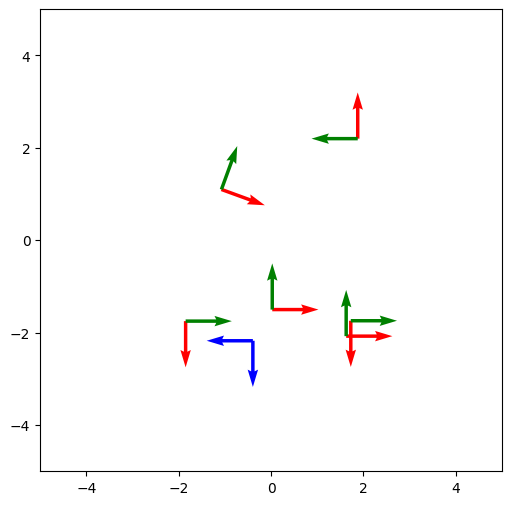

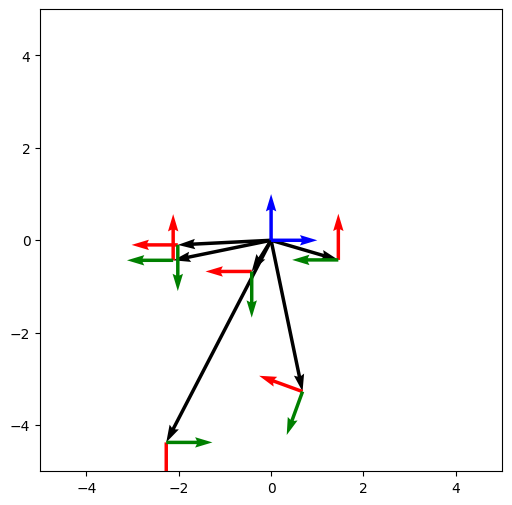

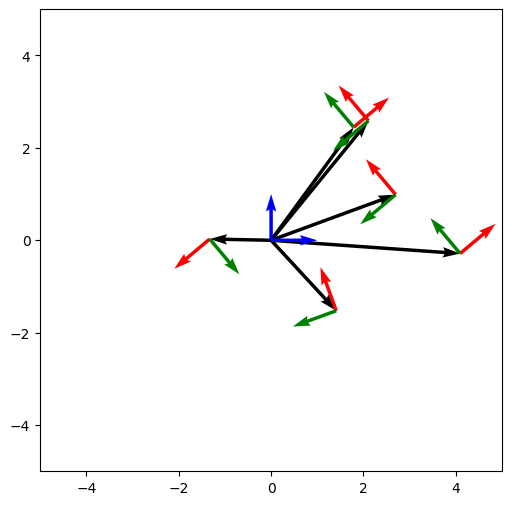

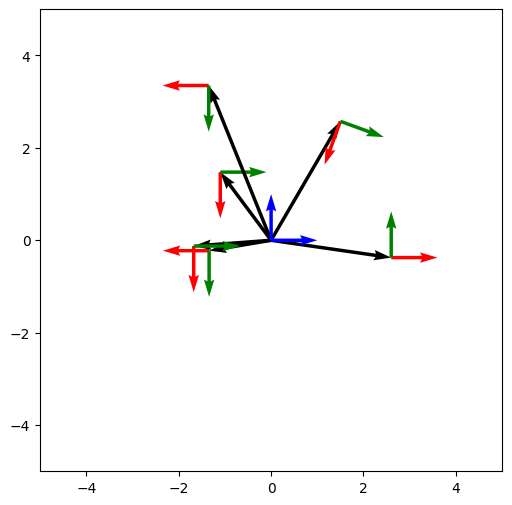

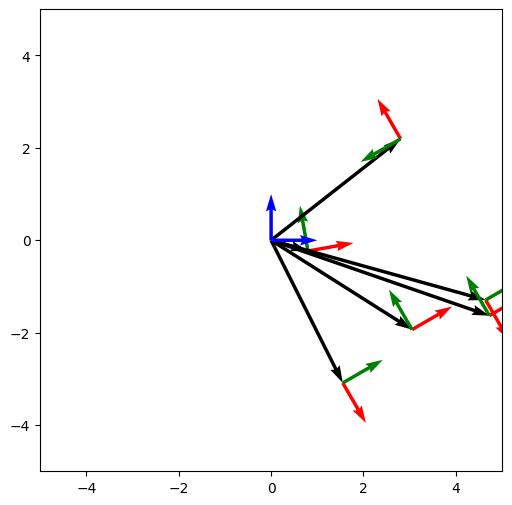

In [6]:
sim.setStepping (True)
sim.loadScene ("C:/Users/tatia/Desktop/UFMG/RM/TP1/TP1_2.ttt")
sim.startSimulation ()

bill = CoppeliaObject ("/Bill")
chair = CoppeliaObject ("/swivelChair")
cupboard = CoppeliaObject ("/cupboard")
division = CoppeliaObject ("/20cmHighWall100cm")
plant = CoppeliaObject ("/indoorPlant")
robot = CoppeliaObject ("/PioneerP3DX")
table = CoppeliaObject ("/customizableTable")

coppelia_objects = (bill, chair, cupboard, division, plant, table)

plot_world (coppelia_objects)
plot_world_by_robot (coppelia_objects, robot)
robot.update_location ([1.0, 1.2, robot.global_position[2]], [0,0,np.deg2rad(-130)])
plot_world_by_robot (coppelia_objects, robot)
robot.update_location ([1.5, -0.4, robot.global_position[2]], [0,0,np.deg2rad(90)])
plot_world_by_robot (coppelia_objects, robot)
robot.update_location ([-1.65, 1.7, robot.global_position[2]], [0,0,np.deg2rad(-30)])
plot_world_by_robot (coppelia_objects, robot)

sim.stopSimulation()
time.sleep(5)

[[ 1.        0.000009  0.000247 -0.001419]
 [-0.000009  1.       -0.000022  0.000025]
 [-0.000247  0.000022  1.        0.149838]
 [ 0.        0.        0.        1.      ]]
[[-0.999995  0.000003 -0.00312  -0.39447 ]
 [-0.000003 -1.        0.000097 -2.175   ]
 [-0.00312   0.000097  0.999995  0.13879 ]
 [ 0.        0.        0.        1.      ]]
[[-0.642788  0.766044  0.        1.      ]
 [-0.766044 -0.642788  0.        1.2     ]
 [ 0.        0.        1.        0.138793]
 [ 0.        0.        0.        1.      ]]
[[ 0.       -1.        0.        1.5     ]
 [ 1.        0.        0.       -0.4     ]
 [ 0.        0.        1.        0.138793]
 [ 0.        0.        0.        1.      ]]
[[ 0.866025  0.5       0.       -1.65    ]
 [-0.5       0.866025  0.        1.7     ]
 [ 0.        0.        1.        0.138793]
 [ 0.        0.        0.        1.      ]]


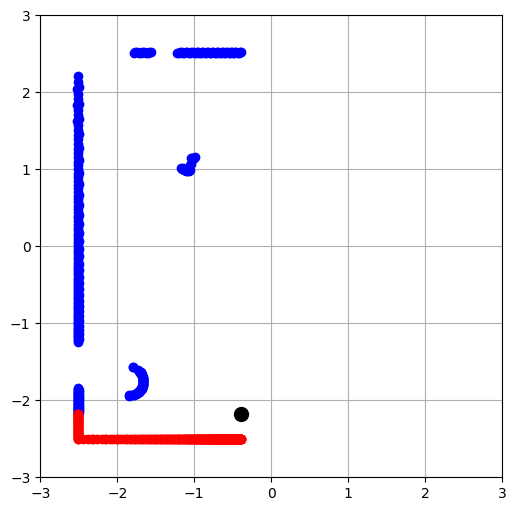

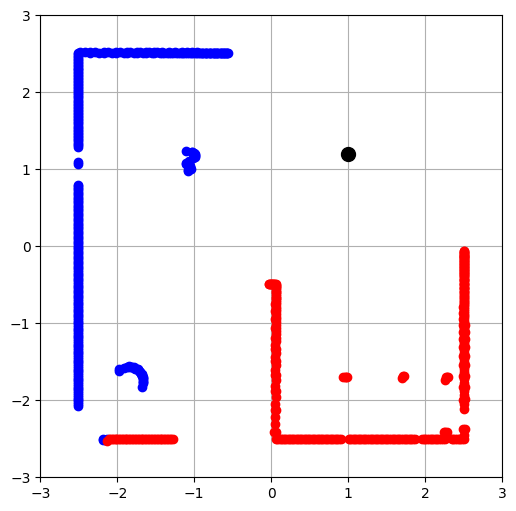

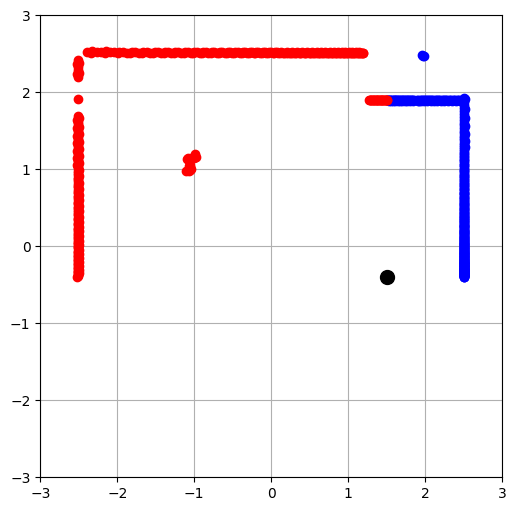

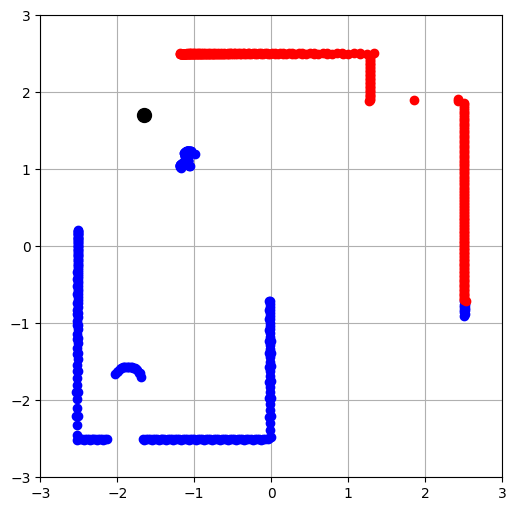

In [7]:
sim.loadScene ("C:/Users/tatia/Desktop/UFMG/RM/TP1/TP1_5.ttt")
sim.startSimulation ()

new_robot = CoppeliaObject ("/Pioneer_p3dx")
laser = CoppeliaObject ("/fastHokuyo")

laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"

laser_to_robot_transformation = to_robot_transformation_matrix (laser, new_robot)
print (laser_to_robot_transformation)

plot_world_by_laser (new_robot, laser_range_data, laser_angle_data, laser_to_robot_transformation)
new_robot.update_location ([1.0, 1.2, robot.global_position[2]], [0,0,np.deg2rad(-130)])
plot_world_by_laser (new_robot, laser_range_data, laser_angle_data, laser_to_robot_transformation)
new_robot.update_location ([1.5, -0.4, robot.global_position[2]], [0,0,np.deg2rad(90)])
plot_world_by_laser (new_robot, laser_range_data, laser_angle_data, laser_to_robot_transformation)
new_robot.update_location ([-1.65, 1.7, robot.global_position[2]], [0,0,np.deg2rad(-30)])
plot_world_by_laser (new_robot, laser_range_data, laser_angle_data, laser_to_robot_transformation)

sim.stopSimulation ()
time.sleep (5)

In [8]:
sim.loadScene("C:/Users/tatia/Desktop/UFMG/RM/TP1/TP1_6.ttt")
sim.startSimulation()

l_wheel = sim.getObjectHandle (new_robot.name + '_leftMotor')
r_wheel = sim.getObjectHandle (new_robot.name + '_rightMotor')

robot_length = 0.381   # Metros
wheel_radius = 0.0975  # Metros

# Lembrar de habilitar o 'Real-time mode'
t = 0
startTime = time.time()
lastTime = startTime

while t < 60:
    
    now = time.time()
    dt = now - lastTime

    # Fazendo leitura do laser   
    raw_range_data, raw_angle_data = read_sensor_data (laser_range_data, laser_angle_data)
    laser_data = np.array ([raw_angle_data, raw_range_data]).T
    
    # Velocidade básica (linear, angular)
    v = 0
    w = np.deg2rad (0)      

    frente = int (len (laser_data) / 2)
    lado_direito = int (len (laser_data) * 1 / 4)
    lado_esquerdo = int (len (laser_data) * 3 / 4)
    
    if laser_data[frente, 1] > 2:
        v = .5
        w = 0
    elif laser_data[lado_direito, 1] > 2:
        v = 0
        w = np.deg2rad (-30)
    elif laser_data[lado_esquerdo, 1] > 2:
        v = 0
        w = np.deg2rad (30)
    
    # Modelo cinemático
    wl = v / wheel_radius - (w * robot_length) / (2 * wheel_radius)
    wr = v / wheel_radius + (w * robot_length) / (2 * wheel_radius)
    
    # Enviando velocidades
    sim.setJointTargetVelocity (l_wheel, wl)
    sim.setJointTargetVelocity (r_wheel, wr)        

    t = t + dt  
    lastTime = now

# Parando o robô    
sim.setJointTargetVelocity(r_wheel, 0)
sim.setJointTargetVelocity(l_wheel, 0)

sim.stopSimulation()